#To download the dataset from the drive location, please this following commands

!pip install gdown

import gdown

# Shared folder link
folder_url = 'https://drive.google.com/drive/folders/157YcTuqNeYUu18k_4MnKcPPgcBAIsqtO?usp=drive_link'

# Download the folder
gdown.download_folder(folder_url, output='dataset_folder', quiet=False, use_cookies=False)


In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from google.colab import files
from PIL import Image

In [ ]:
# Applying CLAHE Preprocessing Function
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

In [ ]:
# Preprocessing and Loading Data with CLAHE
def load_images_with_clahe(folder_path, label, target_size=(224, 224)):
    images, labels = [], []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = apply_clahe(img)
            img = cv2.resize(img, target_size)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

base_path = '/content/drive/MyDrive/ISIC_image_data'
train_benign, yb1 = load_images_with_clahe(os.path.join(base_path, 'Train/Benign'), 0)
train_malignant, ym1 = load_images_with_clahe(os.path.join(base_path, 'Train/Malignant'), 1)
val_benign, yb2 = load_images_with_clahe(os.path.join(base_path, 'Val/Benign'), 0)
val_malignant, ym2 = load_images_with_clahe(os.path.join(base_path, 'Val/Malignant'), 1)

X_train = np.concatenate([train_benign, train_malignant])
y_train = np.concatenate([yb1, ym1])
X_val = np.concatenate([val_benign, val_malignant])
y_val = np.concatenate([yb2, ym2])

from tensorflow.keras.applications.resnet50 import preprocess_input
# Converts RGB to BGR
# Subtracts ImageNet mean pixel values
# Ensures the input format matches what ResNet50 expects

X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

y_train_cat = to_categorical(y_train, 2)
y_val_cat = to_categorical(y_val, 2)

In [ ]:
# Defining and Training ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(2)}

# Fine-tune the last 30 layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=15, width_shift_range=0.1, height_shift_range=0.1)
train_generator = datagen.flow(X_train, y_train_cat, batch_size=32)

# Train
model.fit(train_generator, epochs=7, validation_data=(X_val, y_val_cat), class_weight=class_weights)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 137s 878ms/step - accuracy: 0.7782 - loss: 0.4799 - val_accuracy: 0.8133 - val_loss: 0.4366
Epoch 2/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 43s 496ms/step - accuracy: 0.9224 - loss: 0.2011 - val_accuracy: 0.8042 - val_loss: 0.8556
Epoch 3/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 45s 521ms/step - accuracy: 0.9521 - loss: 0.1342 - val_accuracy: 0.8584 - val_loss: 0.4471
Epoch 4/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 44s 496ms/step - accuracy: 0.9522 - loss: 0.1216 - val_accuracy: 0.8660 - val_loss: 0.6829
Epoch 5/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 45s 514ms/step - accuracy: 0.9625 - loss: 0.1069 - val_accuracy: 0.8645 - val_loss: 0.5279
Epoch 6/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 45s 514ms/step - accuracy: 0.9688 - loss: 0.0894 - val_accuracy: 0.8660 - val_loss: 0.5265
Epoch 7/7
87/87 ━━━━━━━━━━━━━━━━━━━━ 45s 514ms/step - accuracy: 0.9657 - loss: 0.0807 - val_accuracy: 0.8690 - val_loss: 0.5647


In [ ]:
# Evaluation - Precision, Recall, F1-Score
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_val, y_pred_classes, target_names=["Benign", "Malignant"]))

21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step
              precision    recall  f1-score   support

      Benign       0.87      0.88      0.87       339
   Malignant       0.87      0.86      0.87       325

    accuracy                           0.87       664
   macro avg       0.87      0.87      0.87       664
weighted avg       0.87      0.87      0.87       664



In [ ]:
# Evaluation - Accuracy
acc = accuracy_score(y_val, y_pred_classes)
print(f"Accuracy: {acc*100:.4f} %")

Accuracy: 86.8976 %


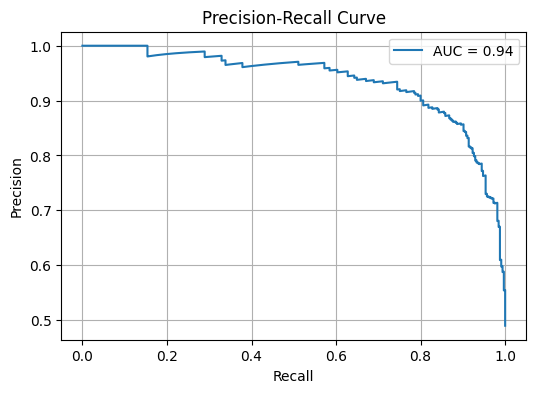

In [ ]:
# Evaluation Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_pred[:,1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# For Custom Testing - Upload and Predict a Single Image
uploaded = files.upload()
for fname in uploaded.keys():
    img_path = fname
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = apply_clahe(img)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img / 255.0, axis=0)
    pred = model.predict(img)
    label = "Malignant" if np.argmax(pred) == 1 else "Benign"
    print(f"Prediction: {label}")

    pred = model.predict(img)[0]  # Getting the prediction array
    class_idx = np.argmax(pred)
    confidence = pred[class_idx] * 100  # Convert to percentage

    label = "Malignant" if class_idx == 1 else "Benign"
    print(f"Prediction: {label} ({confidence:.2f}% confidence)")

Saving ISIC_0034546.jpg to ISIC_0034546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction: Benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction: Benign (92.93% confidence)
